### **Librerías**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

### **ETL**

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
original_data = pd.read_csv("/content/drive/MyDrive/DNI_Data.csv")
original_data

,Month,DNI,Cloud Type,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature,Pressure
0,1,0,1,-12,156.44,5.4,67.86,-8,920
1,1,0,4,-12,155.80,5.3,67.84,-8,920
2,1,0,4,-12,153.74,5.3,68.31,-8,920
3,1,0,4,-12,150.58,5.1,68.30,-8,920
4,1,0,4,-12,146.64,5.0,69.20,-8,920
...,...,...,...,...,...,...,...,...,...
17515,12,0,1,-12,141.43,5.2,68.51,-8,920
17516,12,0,1,-12,145.95,5.2,68.30,-8,920
17517,12,0,7,-12,149.99,5.2,68.28,-8,920
17518,12,0,7,-12,153.30,5.2,67.91,-8,920


### **Data Clean and Validation**

In [5]:
# Data Types are Correct, but is better to have strings in Month and Cloud Type
original_data.dtypes 

Month                   int64
DNI                     int64
Cloud Type              int64
Dew Point               int64
Solar Zenith Angle    float64
Wind Speed            float64
Relative Humidity     float64
Temperature             int64
Pressure                int64
dtype: object

In [6]:
original_data['Month']= original_data['Month'].astype('string')
original_data['Cloud Type']= original_data['Cloud Type'].astype('string')

In [7]:
#There are not Nan values
original_data.isnull().sum()

Month                 0
DNI                   0
Cloud Type            0
Dew Point             0
Solar Zenith Angle    0
Wind Speed            0
Relative Humidity     0
Temperature           0
Pressure              0
dtype: int64

### **EDA**

In [8]:
numeric_columns = original_data.select_dtypes(include=np.number).columns.tolist()
label_columns = ["Month","Cloud Type"]

In [9]:
original_data.describe()

,DNI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature,Pressure
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,225.353311,0.529053,89.664271,3.443927,60.729293,9.298459,918.647260
std,327.743833,8.649458,32.763676,1.885001,21.429893,11.804974,6.942311
min,0.000000,-28.000000,23.130000,0.100000,9.830000,-22.000000,890.000000
25%,0.000000,-4.000000,64.960000,2.000000,44.920000,0.000000,910.000000
50%,0.000000,0.000000,89.590000,3.200000,61.490000,9.000000,920.000000
75%,458.000000,7.000000,114.172500,4.600000,76.892500,18.000000,920.000000
max,1036.000000,18.000000,156.860000,13.300000,100.000000,40.000000,950.000000


In [10]:
original_data.describe(exclude=[np.number])

,Month,Cloud Type
count,17520,17520
unique,12,10
top,1,0
freq,1488,6109


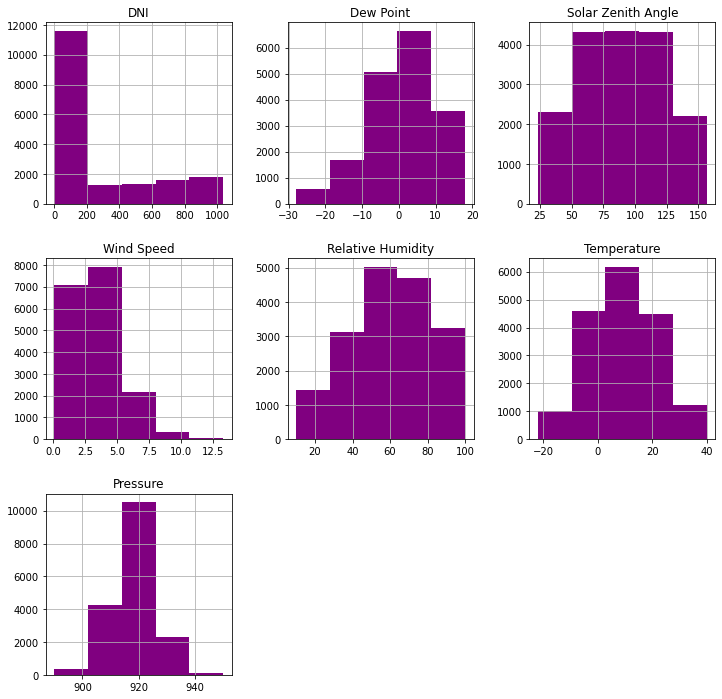

In [11]:
k = int(np.ceil(1 + np.log2(original_data.shape[1]))) # Using Sturges Rule to determine the number of bins
original_data[numeric_columns].hist(bins = k, figsize=(12,12),color="purple")
plt.show()

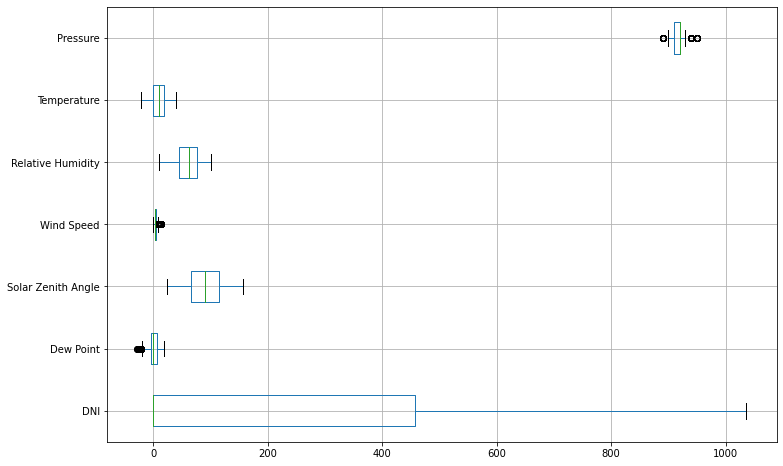

In [12]:
plt.figure(figsize=(12,8))
original_data.boxplot(vert=False)
plt.show()

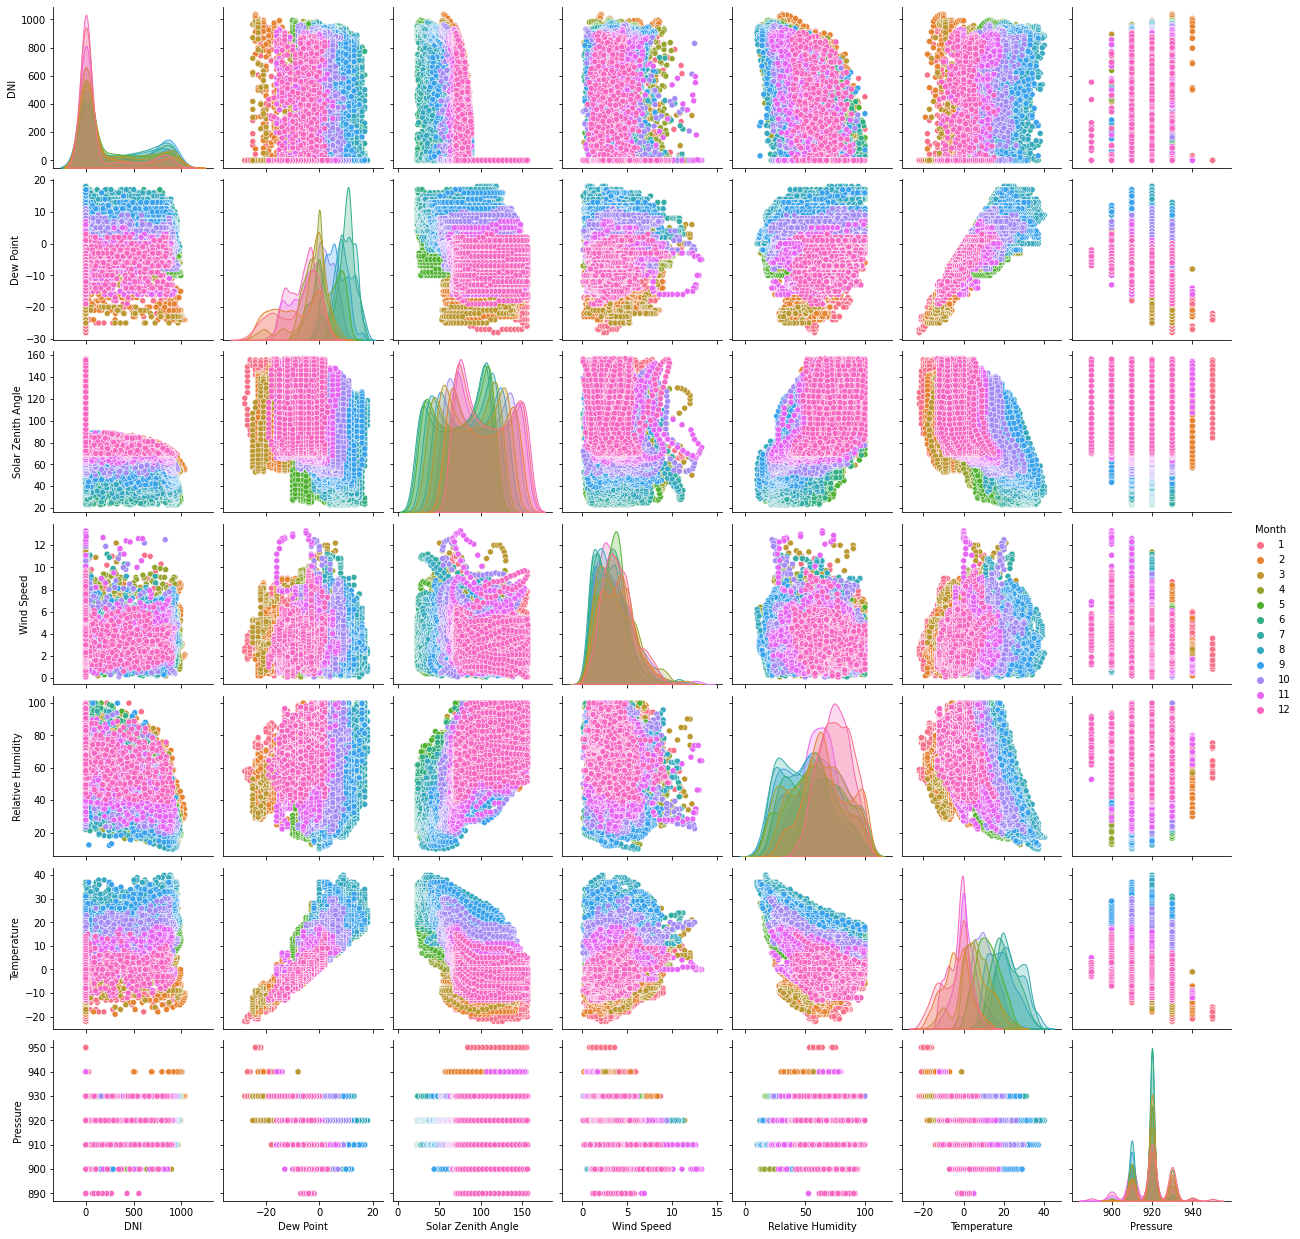

In [14]:
plotf = original_data[numeric_columns + ["Month"]]
sns.pairplot(plotf,hue="Month")
plt.show()

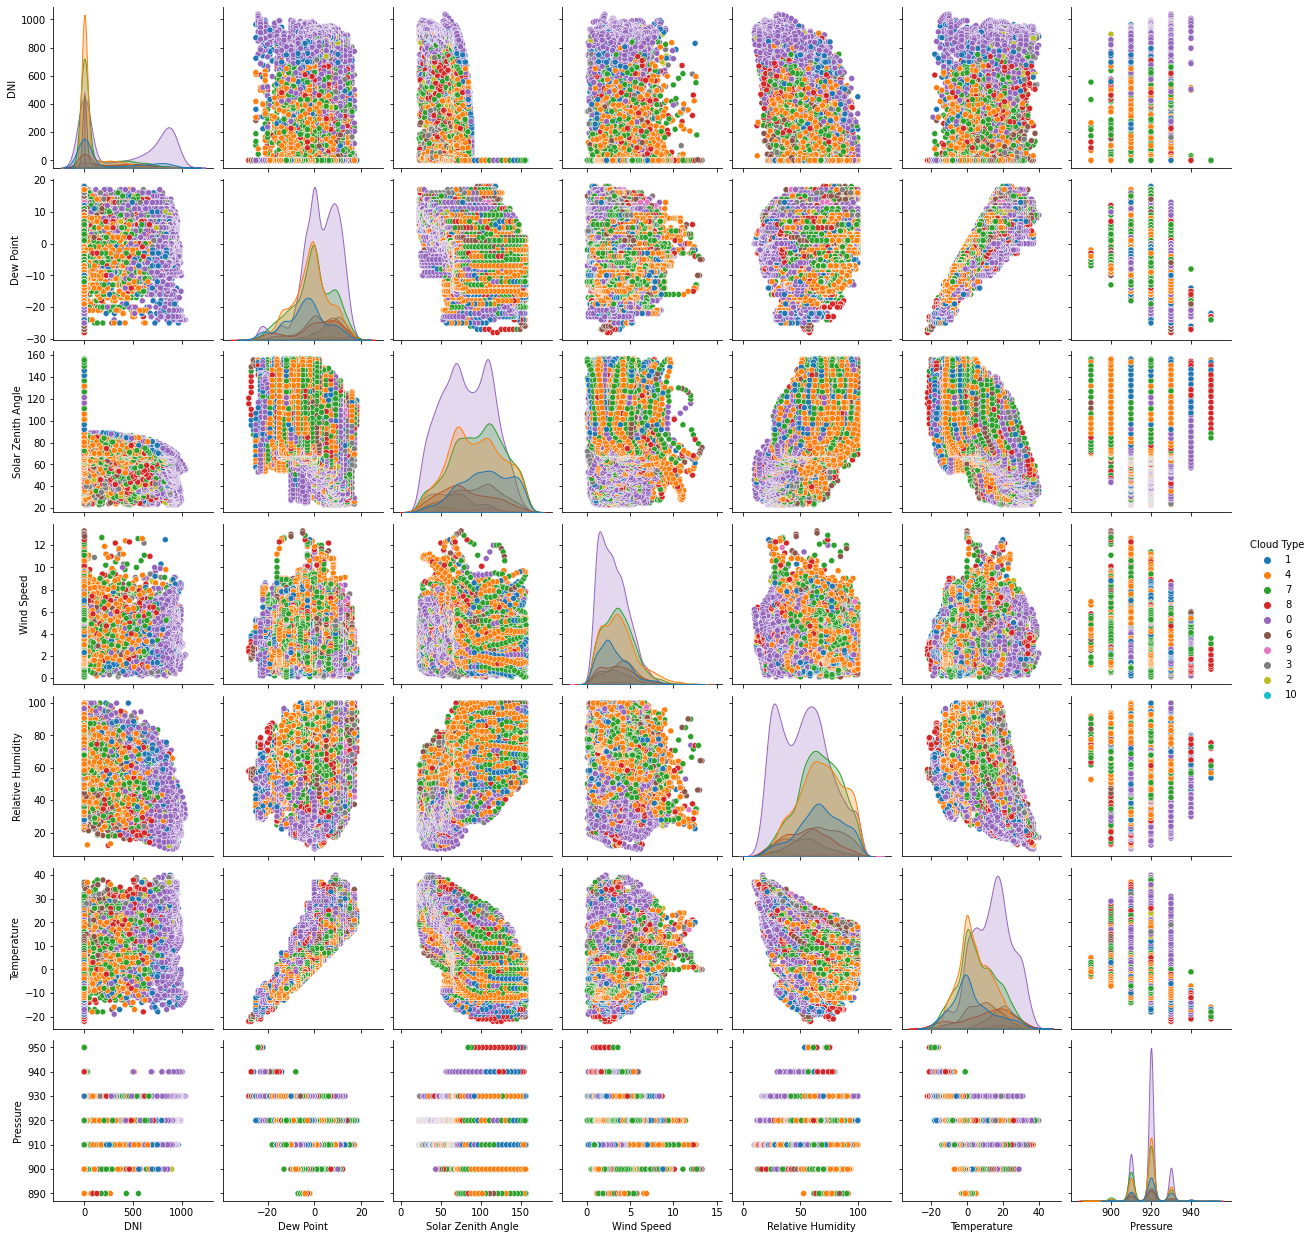

In [15]:
plotf = original_data[numeric_columns + ["Cloud Type"]]
sns.pairplot(plotf,hue="Cloud Type")
plt.show()

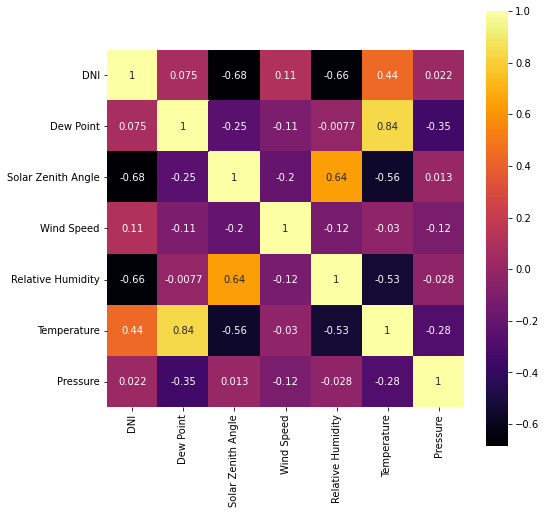

In [13]:
correlation = original_data[numeric_columns].corr()
plt.figure(figsize = (8,8))
ax = sns.heatmap(correlation,vmax=1, square = True, cmap="inferno",annot=True)

### **Choosing Best Predictors**

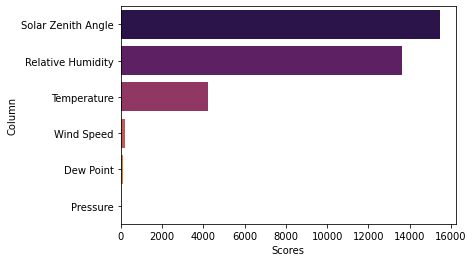

In [16]:
kb = SelectKBest(k="all", score_func=f_regression)
target = "DNI"
xp = original_data[[x for x in original_data[numeric_columns].columns if x!= target]]
yp = original_data[target]

fit = kb.fit(xp, yp.values.ravel())
index = np.argsort(fit.scores_)[::-1]
features = [] # These list are using to store the scores and features
scores = []
for i in range(len(index)):
    features.append(xp.columns[index[i]])
    scores.append(fit.scores_[[index[i]][0]]) #In this part I am store the scores and features

# This dataframe is used to create a better Plot
Best= {'Column': features, 'Scores': scores }  
df = pd.DataFrame(Best)  
Best10= {'Column': features[0:10], 'Scores': scores[0:10] }  
df10 = pd.DataFrame(Best10)  
# Here we plot the Data Frame
sns.barplot(x='Scores',y='Column',data=df10,orient="h",palette="inferno")
plt.show()

### **Check Normality**

**Solar Angle**

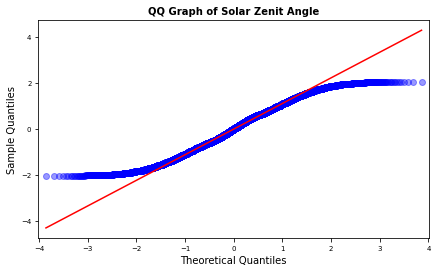

In [17]:
Solar_angle = original_data["Solar Zenith Angle"]
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    Solar_angle,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('QQ Graph of Solar Zenit Angle', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

**Relative Humidity**

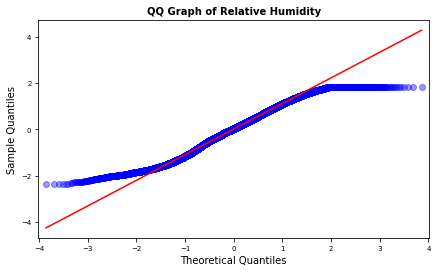

In [18]:
humidity = original_data["Relative Humidity"]
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    humidity,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('QQ Graph of Relative Humidity', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

**Temperature**

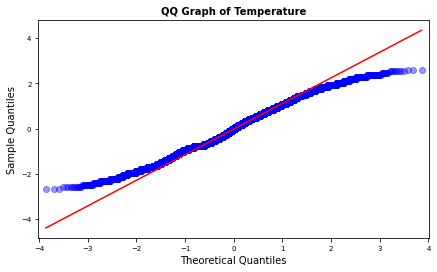

In [19]:
temperature = original_data["Temperature"]
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(
    temperature,
    fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('QQ Graph of Temperature', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)

### **Split Data**

In [20]:
xs = original_data[["Solar Zenith Angle","Relative Humidity","Temperature"]]
y = original_data["DNI"]

X_train, X_test, y_train, y_test = train_test_split(xs, y,test_size=0.2,random_state=3)

In [21]:
print(f"The X train values are {X_train.shape[0]}")
print(f"The X test values are {X_test.shape[0]}")
print(f"The Y values are {y_train.shape[0]}")
print(f"The Y test values are {y_test.shape[0]}")
xs_labels = ["Solar Zenith Angle","Relative Humidity","Temperature"]

The X train values are 14016
The X test values are 3504
The Y values are 14016
The Y test values are 3504


### **Preprocesing Data**

In [22]:
pipeline = Pipeline([
      ("Scaler", StandardScaler()),
      ("Transformation", PowerTransformer(method='yeo-johnson'))
])

preprocessing_pipe = ColumnTransformer([
      ("pipeline",pipeline,xs_labels),
])

In [23]:
X_train = preprocessing_pipe.fit_transform(X_train)
X_test  = preprocessing_pipe.transform(X_test)

### **Models and Validation**

- **Linear Regression**

In [24]:
LR = linear_model.LinearRegression()
LR.fit(X_train,y_train.values.ravel())

LinearRegression()

In [25]:
y_pred = LR.predict(X_test)

print('Coefficients:', LR.coef_)
print('Intercept:', LR.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred))
print('Root Mean squared error (RMSE): %.2f'
      % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred))


Coefficients: [-147.95529853 -121.13147375   -1.77285202]
Intercept: 224.07063356164383
Mean squared error (MSE): 49025.82
Root Mean squared error (RMSE): 221.42
Coefficient of determination (R^2): 0.55


- **Ridge Regression**

In [26]:
LRR = linear_model.Ridge(0.3) # We tried 0.1, 0.3, 0.5, 1
LRR.fit(X_train,y_train.values.ravel())

Ridge(alpha=0.3)

In [27]:
y_pred_ridge = LRR.predict(X_test)

print('Coefficients:', LRR.coef_)
print('Intercept:', LRR.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred_ridge))
print('Root Mean squared error (RMSE): %.2f'
      % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred_ridge))

Coefficients: [-147.95158859 -121.12962283   -1.76977484]
Intercept: 224.07063356164383
Mean squared error (MSE): 49025.86
Root Mean squared error (RMSE): 221.42
Coefficient of determination (R^2): 0.55


- **Neural Network**

In [28]:
NN = MLPRegressor(random_state=1, max_iter=2000)
NN.fit(X_train, y_train.values.ravel())

MLPRegressor(max_iter=2000, random_state=1)

In [29]:
y_pred_NN = NN.predict(X_test)
a = mean_squared_error(y_test, y_pred_NN)
b = math.sqrt(a)
r = r2_score(y_test, y_pred_NN)

print('Mean squared error (MSE): %.2f'
      % a)
print('Root Mean squared error (RMSE): %.2f'
      % b)
print('Coefficient of determination (R^2): %.2f'
      % r)


Mean squared error (MSE): 31821.85
Root Mean squared error (RMSE): 178.39
Coefficient of determination (R^2): 0.71
